
This notebook is a supplement to the paper "A fundamental non-classical logic" (https://arxiv.org/abs/2207.06993) by Wesley H. Holliday (wesholliday@berkeley.edu). 

A longer, related notebook for the paper "Compatibility and accessibility: lattice representations for semantics of non-classical and modal logic" (https://arxiv.org/abs/2201.07098) is available at https://github.com/wesholliday/compat-frames. 

To view the notebook online, type the URL of this notebook (https://github.com/wesholliday/fundamental-logic/blob/main/relational-frames.ipynb) into the location field at https://nbviewer.org. GitHub's preview of the notebook might not show all the output that was generated.


# Notebook Outline

### I. [Drawing relational frames](#II)

### II. [Calculating fixpoints of the closure operator](#III)

### III. [Hasse diagrams of the fixpoint lattices](#IV)

### IV. [The $\neg_\vartriangleleft$ operation](#V)

### V. [Frames from Figures 11 and 12](#V)

### VI. [Enumerating lattices with weak pseudocomplementations up to isomorphism](#VI)

### VII. [Representation from Theorem 4.22.4](#VII)


### Preliminaries

In [1]:
from itertools import chain, combinations, product
import copy
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from pprint import pprint
from tqdm.notebook import tqdm
from functools import partial

In [2]:
def powerset(iterable):
    """powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

## I. Drawing relational frames <a id='I'></a>

According to our convention in the paper, to represent the relational frame $(X,\vartriangleleft)$, we draw an arrow from $y$ to $x$ when $x\vartriangleleft y$. Thus, we draw the directed graph $(X,\vartriangleright)$ to represent the relational frame $(X,\vartriangleleft)$.

In [3]:
def domain(rel):
    """given a reflexive relation, returns the domain of the relation"""
    X = {pair[0] for pair in rel}
    
    return X

In [4]:
# when defining reflexive frames, 
# in order to avoid entering pairs (x,x) manually, we use the following:

def reflexive_closure(rel,X):
    """given a binary relation rel on X, returns the reflexive closure of rel"""
    relset = set(rel)

    for x in X:
        if not (x,x) in relset:
            rel.append((x,x))
    return rel

In [5]:
def draw_flipped_digraph(rel,X = None):
    """given a relation rel on X, draw the digraph for the inverse of rel;
    if no X is given, we assume rel is reflexive and take X to be the domain of rel"""
    
    if X is None:
        X = domain(rel)
    
    g = nx.DiGraph()
    g.add_nodes_from(X)
    
    for pair in rel:
        g.add_edge(pair[1],pair[0])
    
    nx.draw(g,with_labels=True)
    plt.show() 

## II. Calculating fixpoints of the closure operator <a id='II'></a>

In [6]:
def closure(A,rel,X = None):
    """given a subset A of X, returns the closure of A according to the closure operator
    c_rel defined in Prop. 4.3.1 of the paper from the given relation rel on X;
    if no X is given, we assume rel is reflexive and take X to be the domain of rel"""

    if X is None:
        X = domain(rel)
    
    Aset = set(A)
    Xset = set(X)
    closure = [x for x in A]
   
    for x in Xset - Aset:
        x_sees = {y for y in X if (y,x) in rel}
        seen_by_A = {z for z in X if any([pair[0]==z and pair[1] in Aset for pair in rel])}
        if x_sees.issubset(seen_by_A):
            closure.append(x)
        
    return closure

For small compatibility frames, we can simply check for each subset whether it is a fixpoint of the closure operator.

In [7]:
def fixpoints(rel,X = None):
    """given a binary relation rel on X, returns the fixpoints of c_rel according to Prop. 4.3.1 in the paper"""

    if X is None:
        X = domain(rel)
    
    fixpts = []
    
    pwrset = powerset(X)

    for A in pwrset:
            
        if A == tuple(closure(A,rel,X)):
            fixpts.append(A)

    return fixpts

To handle larger relational frames, we can use Ganter's algorithm to calculate fixpoints of a closure operator (Ganter B. (2010), "Two Basic Algorithms in Concept Analysis." In: Kwuida L., Sertkaya B. (eds) Formal Concept Analysis. ICFCA 2010. *Lecture Notes in Computer Science*, vol 5986. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-11928-6_22). 

Ganter's algorithm assumes a closure operator on the powerset of a set $X$ where $X$ is an initial segment of the natural numbers (or otherwise linearly ordered). Thus, we include a function to convert a given relational frame to an isomorphic copy whose domain is an initial segment of the natural numbers.

In [8]:
def convert_to_nums(rel, X = None):
    """Given a relational frame, return an isomorphic copy
    whose domain is an initial segment of the natural numbers plus
    a dictionary to go back from natural numbers to the original elements"""
    
    if X is None:
        X = domain(rel)
    
    forward_map = {}
    inverse_map = {}
    count = 0
    
    for x in X:
        forward_map[x] = count
        inverse_map[count] = x
        count += 1   
    
    newrel = []
    
    for pair in rel:
        newrel.append((forward_map[pair[0]],forward_map[pair[1]]))
    
    return newrel, inverse_map

We implement the algorithm on p. 316 of Ganter's paper with the following two functions.

In [9]:
def next_fixpoint(A, rel, X = None):
    """Given a relational frame rel on an initial segment of the natural numbers
    and a subset A, assumed to be a fixpoint, calculate the next fixpoint
    according to Ganter's lectic ordering"""
    
    if X is None:
        X = domain(rel)
        
    Aset = set(A)
    
    for i in reversed(X):
        if not i in Aset:
            iset = set(range(i))
            inter = Aset.intersection(iset)
            union = inter.union({i})
            Anext = closure(union, rel, X)
            if [j for j in Anext if j<i and not j in Aset] == []:
                return tuple(Anext)  

In [10]:
def Ganter_fixpoints(rel, X = None):
    """Given a relational frame rel, return the fixpoints according to Ganter's algorithm;
    if rel is not already on an initial segment of the natural numbers, 
    apply convert_to_nums in order to run next_fixpoint and then apply 
    the inverse map to get corresponding fixpoints for the original rel"""
    
    if X is None:
        X = domain(rel)
        
    if tuple(X) == tuple(range(len(X))):
        
        setX = set(X)
        listX = list(X)
    
        fixpts = [()]
        A = ()
    
        while not set(A) == setX:
            A_next = next_fixpoint(A,rel,listX)
            A = A_next
            fixpts.append(A_next)
        
        return fixpts
    
    else:
        conv = convert_to_nums(rel, X)
        newrel = conv[0]
        inverse = conv[1]
        newX = domain(newrel)
        
        setX = set(newX)
        listX = list(newX)
        
        fixpts = [()]
        A = ()
    
        while not set(A) == setX:
            A_next = next_fixpoint(A,newrel,listX)
            A = A_next
            A_next_inverse = tuple({inverse[a] for a in A_next})
            fixpts.append(A_next_inverse)
        
        return fixpts

Fig. 1, left:


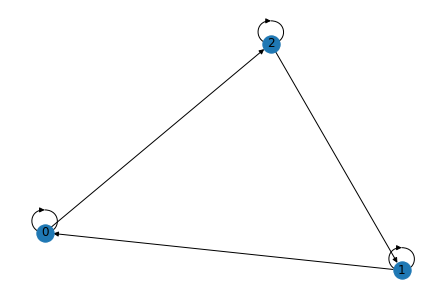

relational frame: [(0, 1), (1, 2), (2, 0), (0, 0), (1, 1), (2, 2)]
fixpoints: [(), (0,), (1,), (2,), (0, 1, 2)]


Fig. 1, right:


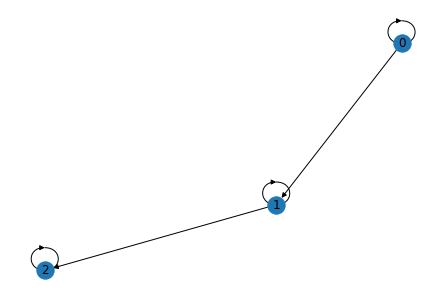

relational frame: [(1, 0), (2, 1), (0, 0), (1, 1), (2, 2)]
fixpoints: [(), (0,), (2,), (1, 2), (0, 1, 2)]


Fig. 2:


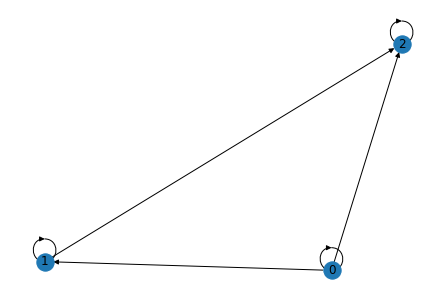

relational frame: [(1, 0), (2, 1), (2, 0), (0, 0), (1, 1), (2, 2)]
fixpoints: [(), (2,), (1, 2), (0, 1, 2)]


Fig. 3, left:


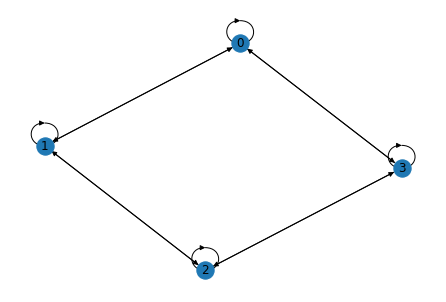

relational frame: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 0), (0, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0,), (1,), (2,), (3,), (0, 1, 2, 3)]


Fig. 3, right:


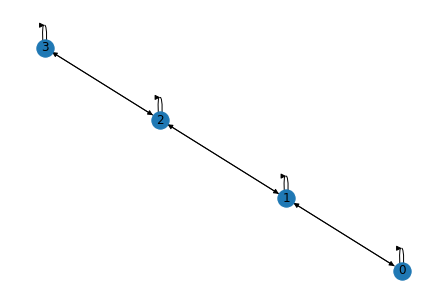

relational frame: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0,), (3,), (0, 1), (2, 3), (0, 1, 2, 3)]


Fig. 6:


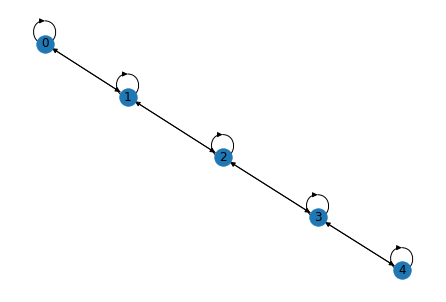

relational frame: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
fixpoints: [(), (0,), (2,), (4,), (0, 1), (0, 4), (3, 4), (0, 1, 2), (2, 3, 4), (0, 1, 2, 3, 4)]


Fig. A.1:


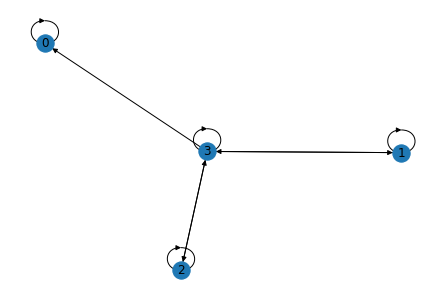

relational frame: [(0, 3), (1, 3), (3, 1), (2, 3), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2, 3)]


Another example not in the paper:


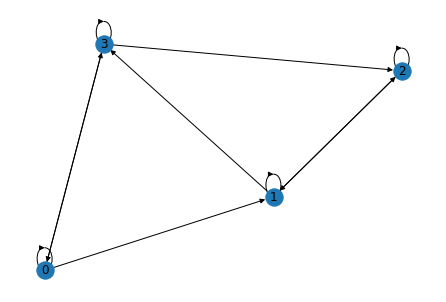

relational frame: [(1, 0), (1, 2), (2, 1), (0, 3), (3, 0), (3, 1), (2, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0,), (2,), (3,), (1, 2), (0, 1, 2, 3)]




In [11]:
# Below are examples from the paper 
# "Compatibility and accessibility: lattice representations for semantics of non-classical and modal logics"

exs = {0: ("Fig. 1, left:",reflexive_closure([(0,1),(1,2),(2,0)],range(3))), 
       1: ("Fig. 1, right:",reflexive_closure([(1,0),(2,1)],range(3))),
       2: ("Fig. 2:",reflexive_closure([(1,0),(2,1),(2,0)],range(3))),
       3: ("Fig. 3, left:",reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2),(3,0),(0,3)],range(4))),
       4: ("Fig. 3, right:",reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2)],range(4))),
       5: ("Fig. 6:",reflexive_closure([(0,1),(1,0), (1,2), (2,1), (2,3), (3,2),(3,4),(4,3)],range(5))),
       6: ("Fig. A.1:",reflexive_closure([(0,3), (1,3), (3,1), (2,3), (3,2)],range(4))),
       7: ("Another example not in the paper:",reflexive_closure([(1,0),(1,2),(2,1),(0,3),(3,0),(3,1),(2,3)],range(4)))
      }
   
for i in range(8):
    print(exs.get(i)[0])
    draw_flipped_digraph(exs.get(i)[1])
    print(f"relational frame: {exs.get(i)[1]}")
    print(f"fixpoints: {fixpoints(exs.get(i)[1])}")
    print("\n")
    
# saving the last example for later:

example_rel = reflexive_closure([(1,0),(1,2),(2,1),(0,3),(3,0),(3,1),(2,3)],range(4))
example_fixpts = fixpoints(example_rel)

## III. Hasse diagrams of the fixpoint lattices <a id='III'></a>

Given a family of fixpoints, we first calculate the proper subset relation between fixpoints, then calculate the associated covering relation, and finally create a networkx digraph for the Hasse diagram of the fixpoint lattice.

In [12]:
def propsubrel(lt):
    """given a list of tuples representing a set of sets, returns the proper subset relation as a list of pairs"""
    propsubrel = []
    
    for A in lt:
        for B in lt:  
            if set(A).issubset(set(B)) and not set(B).issubset(set(A)):
                propsubrel.append((A,B))
                
    return propsubrel

In [13]:
print(propsubrel(example_fixpts))

[((), (0,)), ((), (2,)), ((), (3,)), ((), (1, 2)), ((), (0, 1, 2, 3)), ((0,), (0, 1, 2, 3)), ((2,), (1, 2)), ((2,), (0, 1, 2, 3)), ((3,), (0, 1, 2, 3)), ((1, 2), (0, 1, 2, 3))]


In [14]:
def covering(spo):
    """given a strict partial order spo, returns the associated covering relation"""
    cover = copy.deepcopy(spo)
    for p1 in spo:
        for p2 in spo:
            if p1 in cover and p1[0] == p2[0] and (p2[1],p1[1]) in spo:
                cover.remove(p1)
                break
    return cover

In [15]:
print(covering(propsubrel(example_fixpts)))

[((), (0,)), ((), (2,)), ((), (3,)), ((0,), (0, 1, 2, 3)), ((2,), (1, 2)), ((3,), (0, 1, 2, 3)), ((1, 2), (0, 1, 2, 3))]


In [16]:
def lattice(rel,X = None):
    """given a relation rel on X, returns the Hasse diagram of the lattice of fixpoints"""
    
    if X is None:
        X = set([pair[0] for pair in rel]) 
        
    fix = fixpoints(rel,X)
    cover = covering(propsubrel(fix))
    l = nx.DiGraph()
    l.add_nodes_from(fix)
    l.add_edges_from(cover) 
    
    return l

Since we use graphviz dot to display the lattices, and graphviz dot draws arrows going down, an arrow from $y$ down to $x$ means that $x\leq y$ in our lattice.

In [17]:
def display_lattice(l):
    
    lrev = nx.DiGraph.reverse(l) 
    # We reverse the lattice arrows because graphviz draws all arrows going down, 
    # so if we did not do this, the top element of the lattice would appear at the bottom
    
    pos = graphviz_layout(lrev, prog="dot")
    nx.draw(lrev, pos, with_labels=True, arrowsize=15)
    plt.show() 

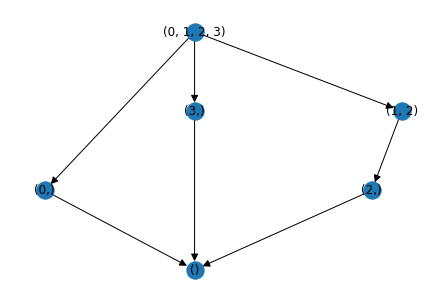

In [18]:
l = lattice(example_rel)

display_lattice(l)

## IV. The $\neg_\vartriangleleft$ operation  <a id='IV'></a>

In this section, we compute the $\neg_\vartriangleleft$ operation on fixpoints from Proposition 4.3.2 in the paper.

In [19]:
def neg_pairs(rel, X = None):
    """given a relation rel on X, return a set of pairs of fixpoints representing the neg function on fixpoints
    as in Proposition 4.3.2 in the paper"""
    
    if X is None:
        X = domain(rel)
        
    fixpts = fixpoints(rel,X)
    
    negrel = []
    
    for A in fixpts:
        Aset = set(A)
        negA = tuple([x for x in X if not any([pair[1]==x and pair[0] in Aset for pair in rel])])
        negrel.append((A,negA))
    
    return negrel

In [20]:
# An example
rel = reflexive_closure([(0,1),(1,2),(2,0)],range(3))
neg_pairs(rel)

[((), (0, 1, 2)), ((0,), (2,)), ((1,), (0,)), ((2,), (1,)), ((0, 1, 2), ())]

In [21]:
def neg_dict(rel, X = None):
    """Like the neg function but returns a dictionary instead of a set of pairs"""
    
    if X is None:
        X = domain(rel)
        
    fixpts = fixpoints(rel,X)
    
    negd = {}
    
    for A in fixpts:
        Aset = set(A)
        negA = tuple([x for x in X if not any([pair[1]==x and pair[0] in Aset for pair in rel])])
        negd[A] = negA
    
    return negd

In [22]:
def lattice_with_neg(rel, X = None):
    """given a relation rel on X, return the Hasse diagram of the lattice of fixpoints plus the negation operation"""
    
    if X is None:
        X = domain(rel)
        
    fix = fixpoints(rel,X)
    cover = covering(propsubrel(fix))
    negrel = neg_pairs(rel,X)
    
    l = nx.MultiDiGraph()
    l.add_nodes_from(fix)
    l.add_edges_from(cover, weight=0) # use weight to distinguish between the covering relation and neg operation
    l.add_edges_from(negrel, weight=1) # use weight to distinguish between the covering relation and neg operation
    
    return l

In [23]:
def display_lattice_with_neg(l):
    """given the Hasse diagram of a lattice with neg operation, 
    draw covering relation with solid arrows and neg operation with dashed arrows"""

    coveredges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==0]
    negedges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==1]

    lat = nx.DiGraph()
    lat.add_nodes_from(l.nodes)
    lat.add_edges_from(coveredges) 

    latrev = nx.DiGraph.reverse(lat) 
    # We reverse the lattice arrows because graphviz draws all arrows going down, 
    # so if we did not do this, the top element of the lattice would appear at the bottom
    
    pos = graphviz_layout(latrev, prog="dot")
    nx.draw_networkx_nodes(latrev,pos)
    nx.draw_networkx_labels(latrev,pos,alpha=.75)
    nx.draw_networkx_edges(latrev,pos,arrowsize=15)
    nx.draw_networkx_edges(l, pos, arrowsize=15, edgelist=negedges,edge_color='r', style="dashed",connectionstyle="arc3,rad=0.2")
    
    plt.show() 

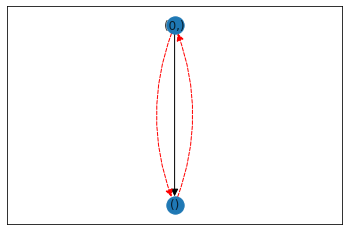

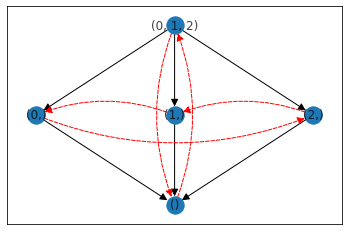

In [24]:
# Examples

l = lattice_with_neg(reflexive_closure([],[0]))

display_lattice_with_neg(l)

l = lattice_with_neg(reflexive_closure([(0,1),(1,2),(2,0)],range(3)))

display_lattice_with_neg(l)


# V. Frames from Figures 11 and 12 <a id='V'></a>

In [25]:
def pseudosymmetric(rel, X=None):
    """Determine whether the binary relation rel is pseudosymmetric 
    as in Proposition 4.12.2(b) of the paper"""

    if X is None:
        X = domain(rel)

    ps = True

    for x in X:
        for y in X:
            if (y,x) in rel:
                found_witness = False
                for z in X:
                    if (z,y) in rel and {w for w in X if (w,z) in rel }.issubset({w for w in X if (w,x) in rel}):
                        found_witness = True
                
                if found_witness == False:
                    ps = False
                    return ps

    return ps


In [26]:
def strongly_pseudosymmetric(rel, X=None):
    """Determine whether the binary relation rel is pseudosymmetric 
    as in Definition 4.15 of the paper"""

    if X is None:
        X = domain(rel)

    ps = True

    for x in X:
        for y in X:
            if (y,x) in rel:
                found_witness = False
                for z in X:
                    if (z,y) in rel and {w for w in X if (w,z) in rel } == {w for w in X if (w,x) in rel}:
                        found_witness = True
                
                if found_witness == False:
                    ps = False
                    return ps

    return ps

## Figure 11, left

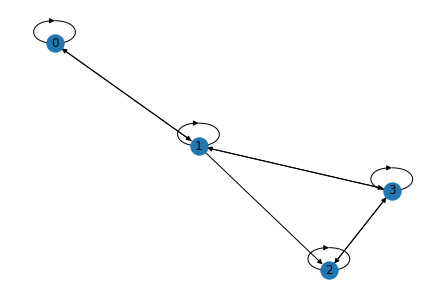

In [27]:
fig11left = reflexive_closure([(0,1), (1,0), (2,1), (1,3), (3,1), (2,3), (3,2)], range(4))

draw_flipped_digraph(fig11left)

In [28]:
pseudosymmetric(fig11left)

True

In [29]:
strongly_pseudosymmetric(fig11left)

False

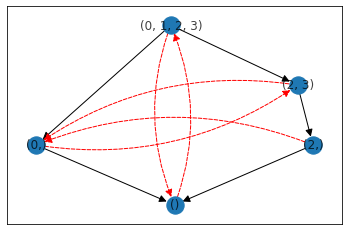

In [30]:
l = lattice_with_neg(fig11left)

display_lattice_with_neg(l)

## Figure 11, middle

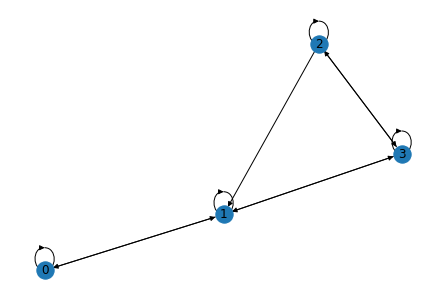

In [31]:
fig11mid = reflexive_closure([(0,1), (1,0), (1,2), (1,3), (3,1), (2,3), (3,2)], range(4))

draw_flipped_digraph(fig11mid)

In [32]:
strongly_pseudosymmetric(fig11mid)

True

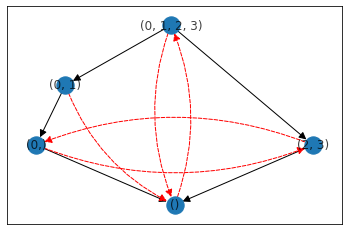

In [33]:
l = lattice_with_neg(fig11mid)

display_lattice_with_neg(l)

## Figure 11, right

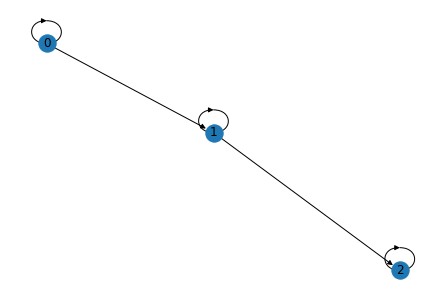

In [34]:
fig11right = reflexive_closure([(1,0), (2,1)], range(3))

draw_flipped_digraph(fig11right)

In [35]:
strongly_pseudosymmetric(fig11right)

False

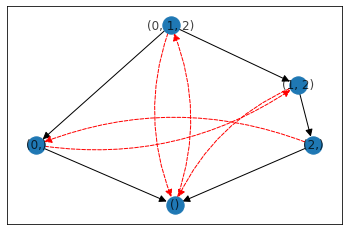

In [36]:
l = lattice_with_neg(fig11right)

display_lattice_with_neg(l)

## Figure 12, left

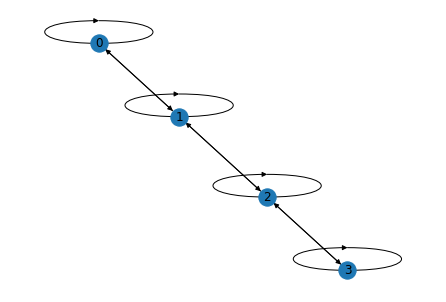

In [37]:
fig12left = reflexive_closure([(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)],range(4))

draw_flipped_digraph(fig12left)

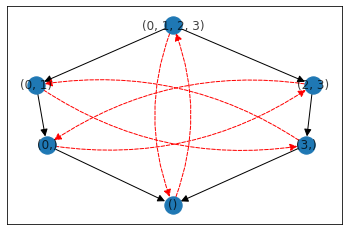

In [38]:
l = lattice_with_neg(fig12left)

display_lattice_with_neg(l)

## Figure 12, right

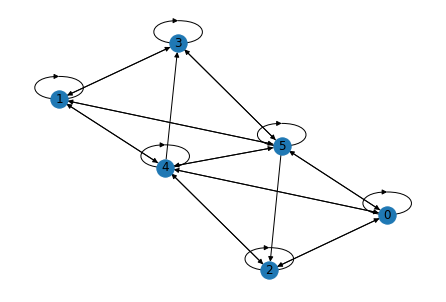

In [39]:
fig12right = [(0, 2), (2, 0), (0, 4), (4, 0), (0, 5), (5, 0), (1, 3), (3, 1), (1, 4), (4, 1), (1, 5), (5, 1), (2, 4), (4, 2), (2, 5), (3, 4), (3, 5), (5, 3), (4, 5), (5, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]

draw_flipped_digraph(fig12right)

In [40]:
strongly_pseudosymmetric(fig12right)

True

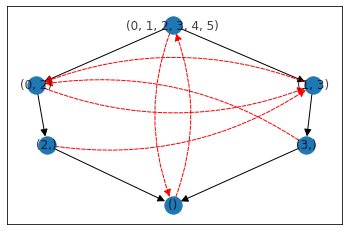

In [41]:
l = lattice_with_neg(fig12right)

display_lattice_with_neg(l)

# VI. Enumerating lattices with weak pseudocomplementations up to isomorphism <a id='VI'></a>

In the /lattices-with-weak-pseudo directory, the file weakpseudo{k}.out contains all lattices of size k with a weak pseudocomplementation up to isomorphism, produced by Mace4 (https://www.cs.unm.edu/~mccune/prover9/) using the following command:

mace4 -n k -m 100000000 < weakpseudo.in | get_interps | isofilter > weakpseudo.out

Below we include code to read these files and display the lattices with negation.

In [42]:
import numpy as np

In [43]:
for line in open(f"lattices-with-weak-pseudo/weakpseudo3.out"):
    print(line)

interpretation( 3, [number = 1,seconds = 0], [

    function(^(_,_), [

        0,0,0,

        0,1,2,

        0,2,2]),

    function(v(_,_), [

        0,1,2,

        1,1,1,

        2,1,2]),

    function(c(_), [1,0,0])]).

% isofilter: input=1, kept=1, checks=0, perms=0, 0.00 seconds.



In [44]:
def algebras_from(filename):
    "Given a Mace4 output file, return a list of pairs of a matrix for the meet operation and list of outputs of negation"

    and_string = '^(_,_)'
    or_string = 'v(_,_)'
    neg_string = 'c(_)'

    inside_and = False
    algebras = []

    for line in open(filename):

        if and_string in line:
            matrix = []
            inside_and = True
            continue

        if inside_and == True and line[7] == ' ':
            length = len(line)
            row = []
            for n in range(length):
                ln = line[n]
                if ln.isdigit():
                    row.append(int(ln))
        
            matrix.append(row)

        if or_string in line:
            inside_and = False

        if neg_string in line:
            negation = []
            length = len(line)
            for n in range(length):
                ln = line[n]
                if ln.isdigit():
                    negation.append(int(ln))

            npmatrix = np.array(matrix)
            algebras.append((npmatrix,negation))

    return algebras

In [45]:
algebras = algebras_from("lattices-with-weak-pseudo/weakpseudo3.out")

for alg in algebras:
    print(alg)

(array([[0, 0, 0],
       [0, 1, 2],
       [0, 2, 2]]), [1, 0, 0])


In [46]:
def lattice_order_from(meet_matrix):
    """Given an np matrix for the meet operation, returns the lattice order"""
    lat_ord = []
    num = meet_matrix.shape[0]
    for n in range(num):
        for m in range(num):
            if meet_matrix[n,m] == n:
                lat_ord.append((n,m))
                
    return lat_ord

In [47]:
def lattice_orders_and_neg_dicts_from(filename):
    "Given a Mace4 output file, return lists of pairs of a lattice order and negation dictionary for each algebra"

    and_string = '^(_,_)'
    or_string = 'v(_,_)'
    neg_string = 'c(_)'

    inside_and = False
    pairs = []

    for line in open(filename):

        if and_string in line:
            matrix = []
            inside_and = True
            continue

        if inside_and == True and line[7] == ' ':
            length = len(line)
            row = []
            for n in range(length):
                ln = line[n]
                if ln.isdigit():
                    row.append(int(ln))
        
            matrix.append(row)

        if or_string in line:
            inside_and = False

        if neg_string in line:
            neg_dict = {}
            arg = 0
            length = len(line)
            for n in range(length):
                ln = line[n]
                if ln.isdigit():
                    neg_dict[arg] = int(ln)
                    arg += 1
            
            npmatrix = np.array(matrix)
            lat_order = lattice_order_from(npmatrix)
            pairs.append((lat_order,neg_dict))

    return pairs

In [48]:
def strict_part(rel):
    return [pair for pair in rel if not pair[0] == pair[1]]

In [49]:
def strict_lattice_order_from(meet_matrix):

    return strict_part(lattice_order_from(meet_matrix))


In [50]:
print(strict_lattice_order_from(algebras[0][0]))

[(0, 1), (0, 2), (2, 1)]


In [51]:
print(covering(strict_lattice_order_from(algebras[0][0])))

[(0, 2), (2, 1)]


In [52]:
def nx_algebras_from(filename):
    "Given a Mace4 output file,"

    and_string = '^(_,_)'
    or_string = 'v(_,_)'
    neg_string = 'c(_)'

    inside_and = False
    digraphs = []

    for line in open(filename):

        if and_string in line:
            matrix = []
            l = nx.MultiDiGraph()
            inside_and = True
            continue

        if inside_and == True and line[7] == ' ':
            length = len(line)
            row = []
            for n in range(length):
                ln = line[n]
                if ln.isdigit():
                    row.append(int(ln))
        
            matrix.append(row)

        if or_string in line:
            npmatrix = np.array(matrix)
            cover = covering(strict_lattice_order_from(npmatrix))
            l.add_edges_from(cover, weight=0)
            inside_and = False

        if neg_string in line:
            neg = []
            arg = 0
            length = len(line)
            for n in range(length):
                ln = line[n]
                if ln.isdigit():
                    neg.append((arg,int(ln)))
                    arg += 1
            
            l.add_edges_from(neg, weight=1)
            digraphs.append(l)

    return digraphs

Lattices of size 2 with weak pseudocomplementations:
#1


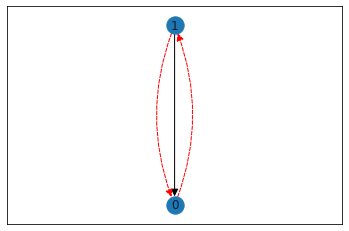

Lattices of size 3 with weak pseudocomplementations:
#1


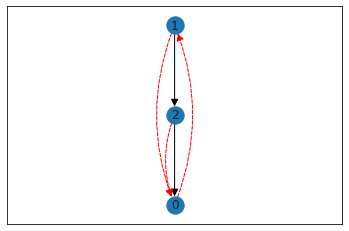

Lattices of size 4 with weak pseudocomplementations:
#1


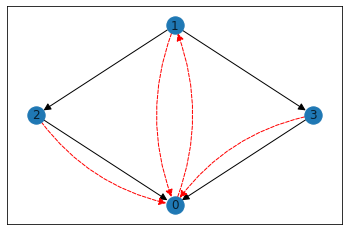

#2


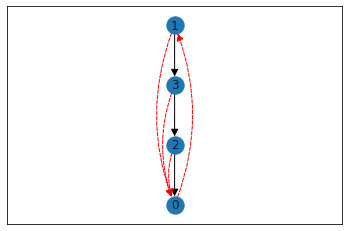

#3


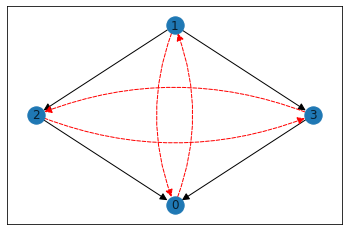

Lattices of size 5 with weak pseudocomplementations:
#1


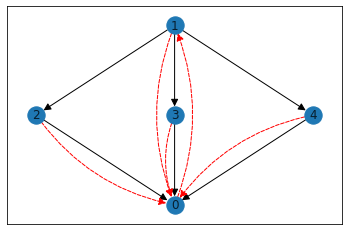

#2


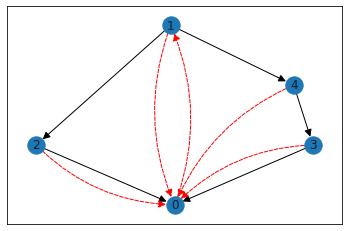

#3


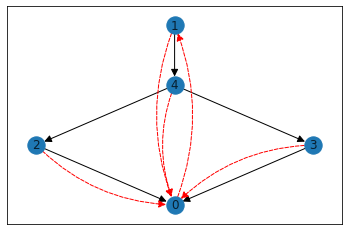

#4


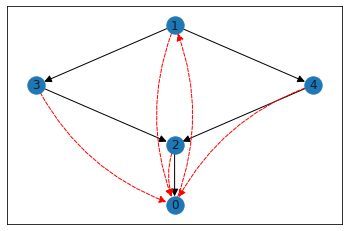

#5


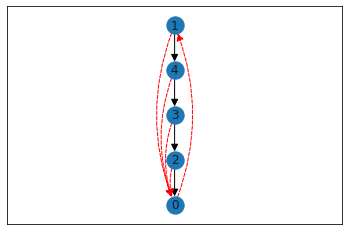

#6


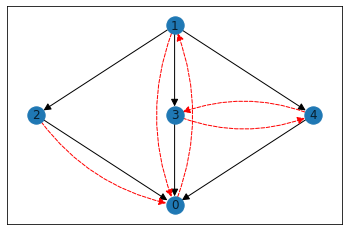

#7


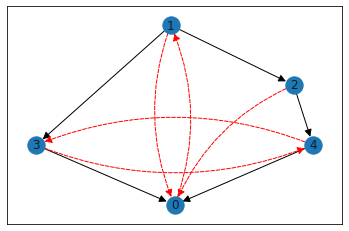

#8


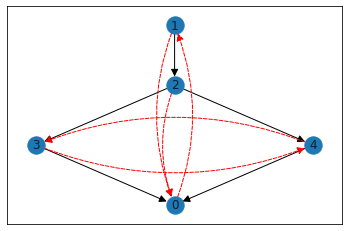

#9


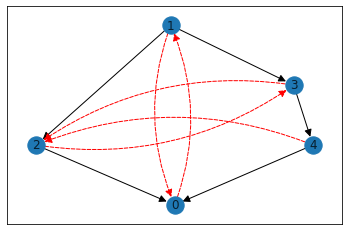

Lattices of size 6 with weak pseudocomplementations:
#1


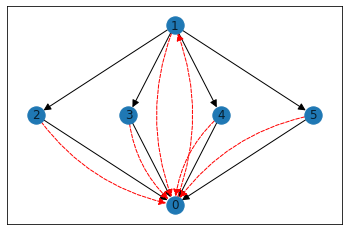

#2


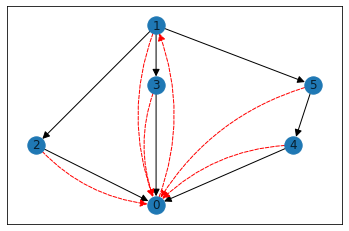

#3


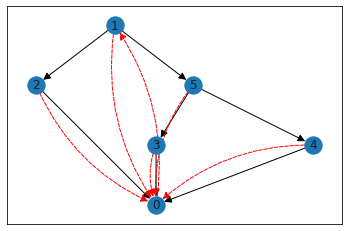

#4


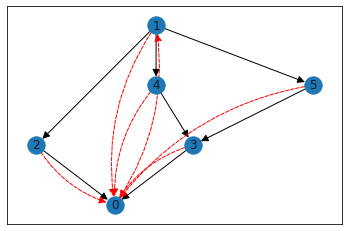

#5


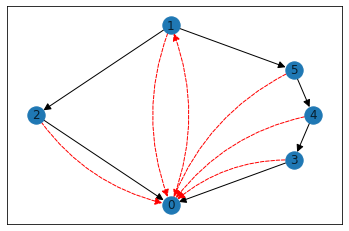

#6


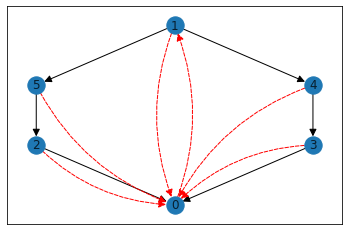

#7


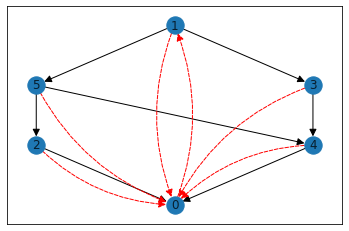

#8


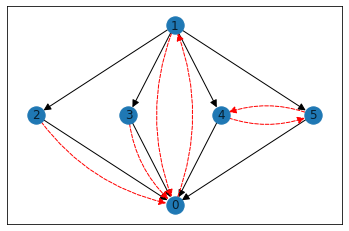

#9


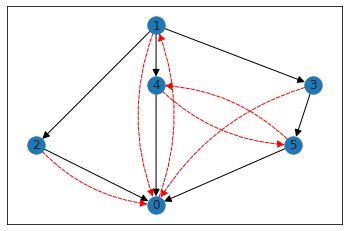

#10


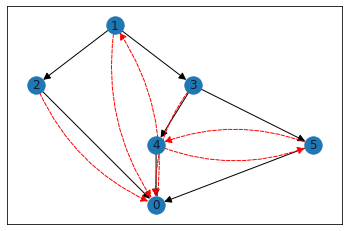

#11


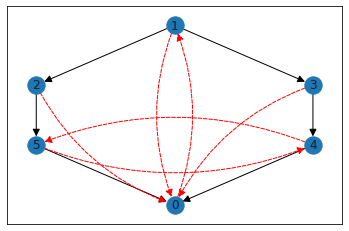

#12


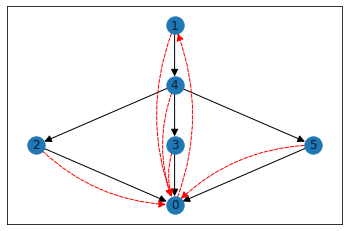

#13


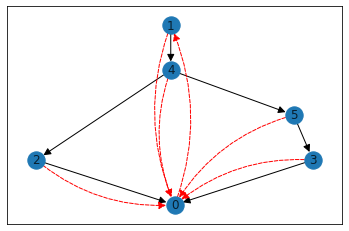

#14


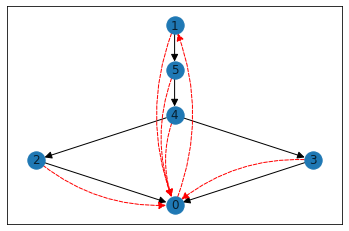

#15


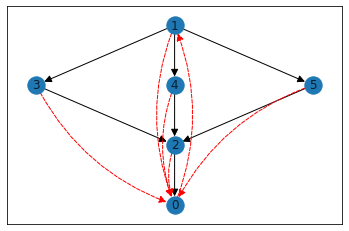

#16


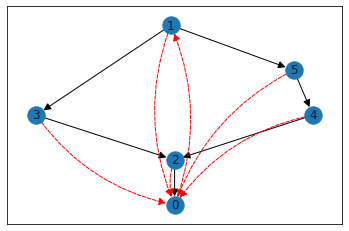

#17


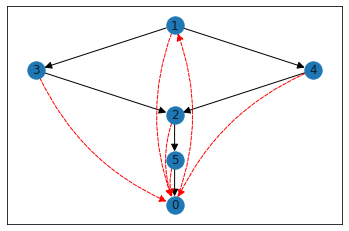

#18


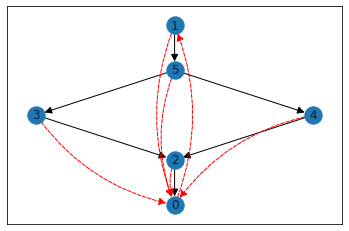

#19


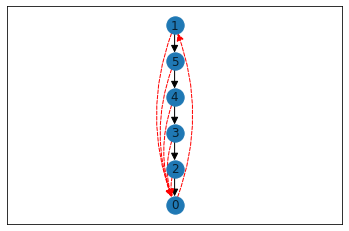

#20


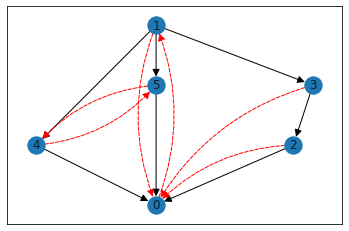

#21


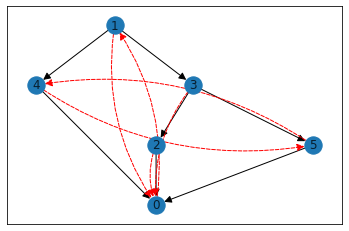

#22


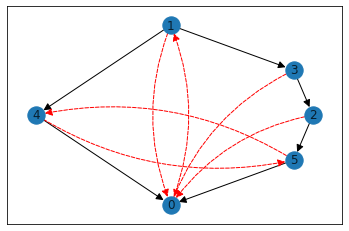

#23


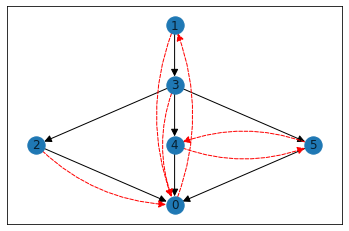

#24


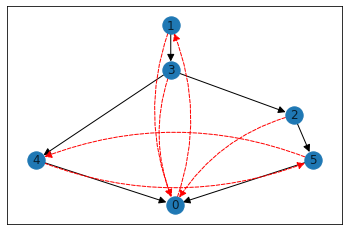

#25


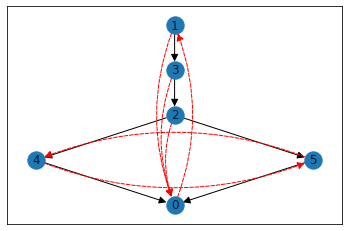

#26


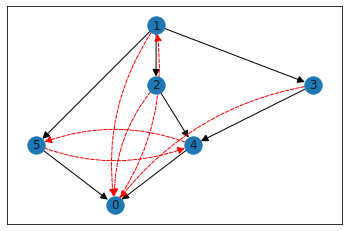

#27


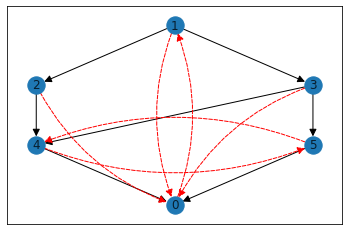

#28


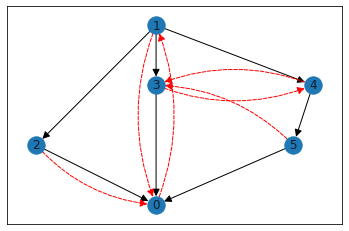

#29


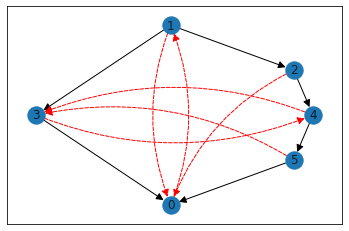

#30


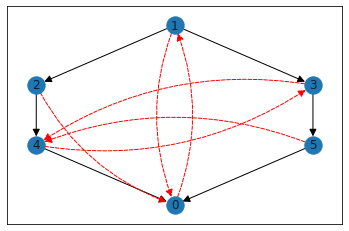

#31


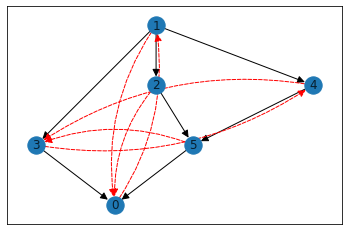

#32


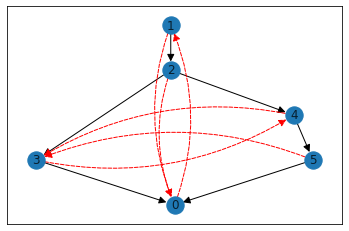

#33


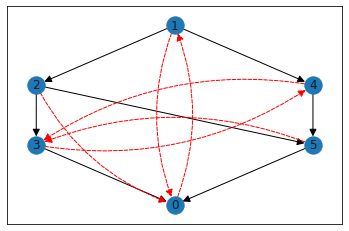

#34


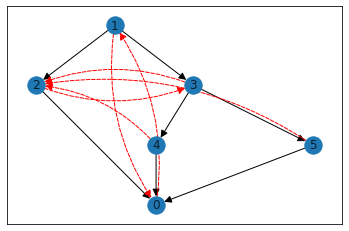

#35


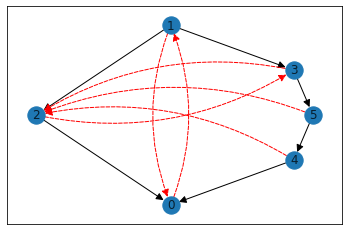

#36


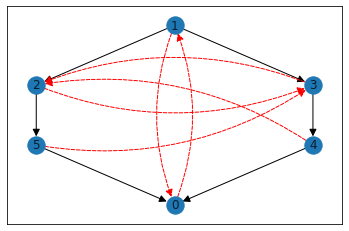

#37


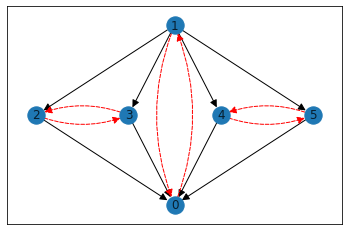

#38


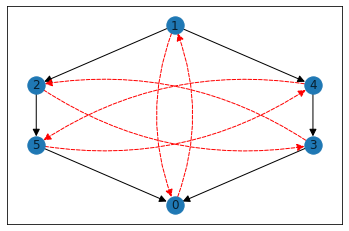

In [53]:
for n in range(2,7):

    print(f"Lattices of size {n} with weak pseudocomplementations:")

    digraphs = nx_algebras_from(f"lattices-with-weak-pseudo/weakpseudo{n}.out")
    count = 1
    for l in digraphs:
        print(f"#{count}")
        display_lattice_with_neg(l)
        count +=1 

# VII. Representation from Theorem 4.22.4 <a id='VII'></a>

In [54]:
def join_irreducibles_Mace_format(covered_by,n):
    """Given the covered-by relation of a lattice of size n, return the join-irreducibles"""
    
    ji = []
    for x in range(n):
        if len([y for y in range(n) if (y,x) in covered_by])==1:
            ji.append(x)
            
    return ji

In [55]:
def meet_irreducibles_Mace_format(covered_by,n):
    """Given the covered-by relation of a lattice of size n, return the meet-irreducibles"""
    
    mi = []
    for x in range(n):
        if len([y for y in range(n) if (x,y) in covered_by])==1:
            mi.append(x)
            
    return mi

In [56]:
def frame_from_lat_with_weak_pseudo(lattice_order,neg_dict,size):

    domain = []
    rel = []

    cover = covering(strict_part(lattice_order))

    ji = join_irreducibles_Mace_format(cover,size)
    mi = meet_irreducibles_Mace_format(cover,size)

    for a in ji:
        domain.append((a,neg_dict[a]))

    for b in mi:
        domain.append((1, b))

    for pair in domain:
        for pair2 in domain:
            if not (pair2[0],pair[1]) in lattice_order:
                rel.append((pair,pair2))

    return domain, rel

####################################################
Lattices of size 2 with weak pseudocomplementations:
Size 2, #1
Lattice with weak pseudocomplementation:


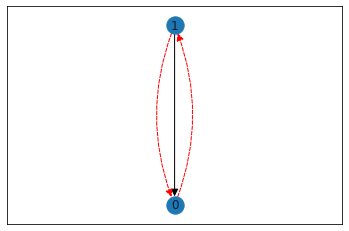

Relational frame of size 1 constructed as in Theorem 4.22.4:


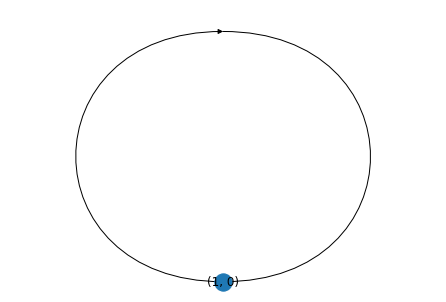

Lattice with negation from relational frame:


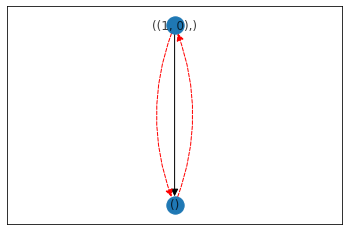

The two algebras are isomorphic.
-------------------------------
####################################################
Lattices of size 3 with weak pseudocomplementations:
Size 3, #1
Lattice with weak pseudocomplementation:


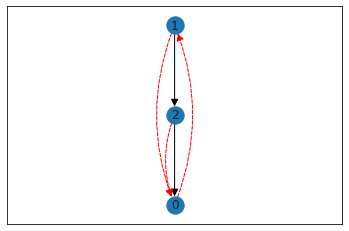

Relational frame of size 3 constructed as in Theorem 4.22.4:


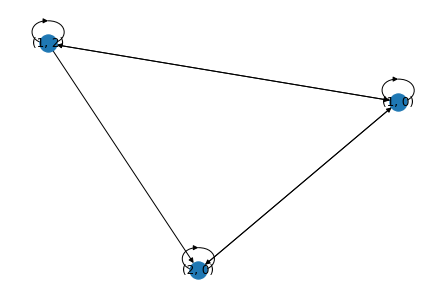

Lattice with negation from relational frame:


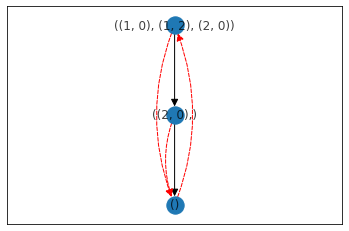

The two algebras are isomorphic.
-------------------------------
####################################################
Lattices of size 4 with weak pseudocomplementations:
Size 4, #1
Lattice with weak pseudocomplementation:


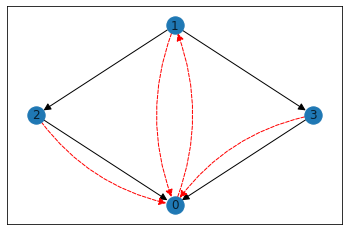

Relational frame of size 4 constructed as in Theorem 4.22.4:


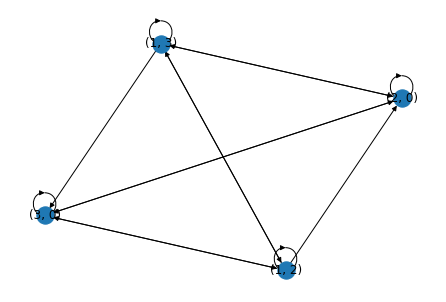

Lattice with negation from relational frame:


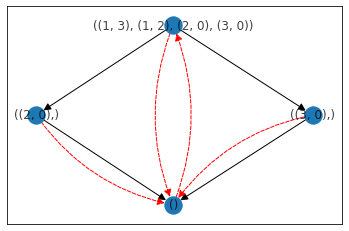

The two algebras are isomorphic.
-------------------------------
Size 4, #2
Lattice with weak pseudocomplementation:


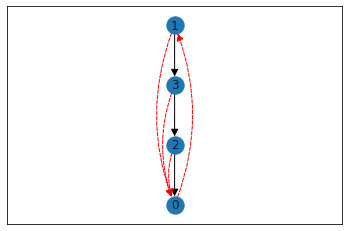

Relational frame of size 5 constructed as in Theorem 4.22.4:


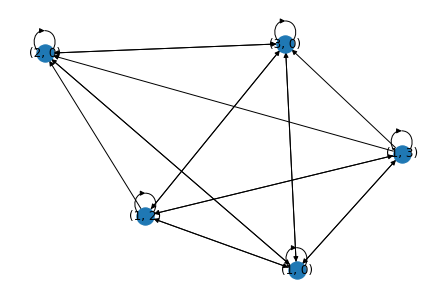

Lattice with negation from relational frame:


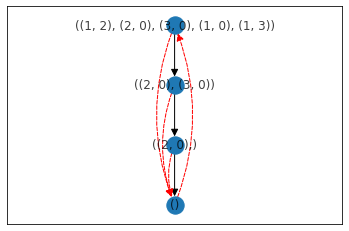

The two algebras are isomorphic.
-------------------------------
Size 4, #3
Lattice with weak pseudocomplementation:


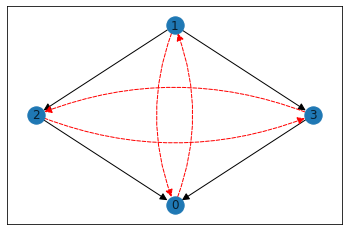

Relational frame of size 4 constructed as in Theorem 4.22.4:


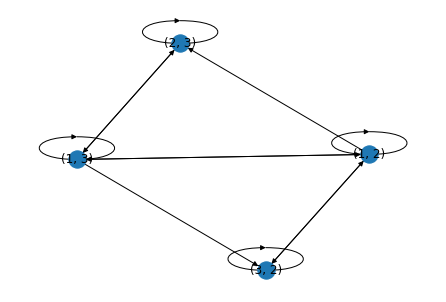

Lattice with negation from relational frame:


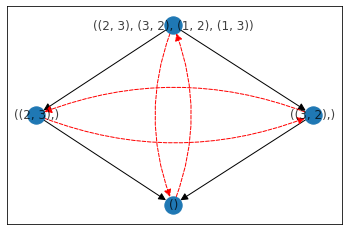

The two algebras are isomorphic.
-------------------------------
####################################################
Lattices of size 5 with weak pseudocomplementations:
Size 5, #1
Lattice with weak pseudocomplementation:


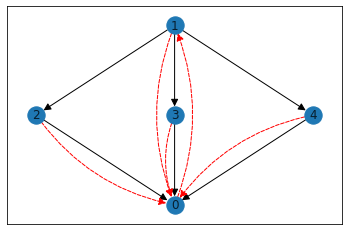

Relational frame of size 6 constructed as in Theorem 4.22.4:


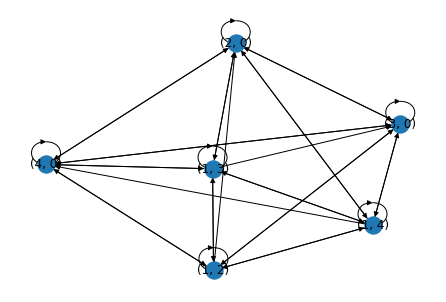

Lattice with negation from relational frame:


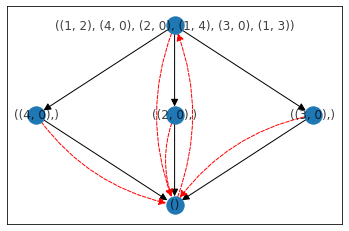

The two algebras are isomorphic.
-------------------------------
Size 5, #2
Lattice with weak pseudocomplementation:


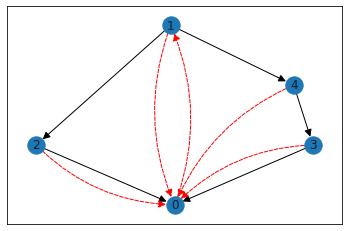

Relational frame of size 6 constructed as in Theorem 4.22.4:


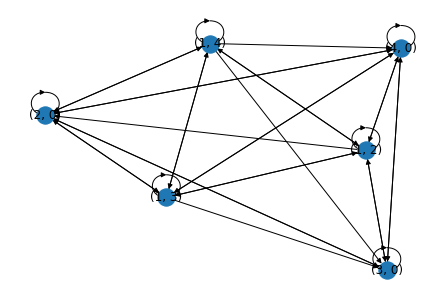

Lattice with negation from relational frame:


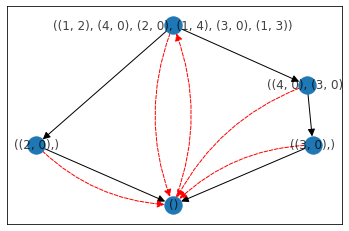

The two algebras are isomorphic.
-------------------------------
Size 5, #3
Lattice with weak pseudocomplementation:


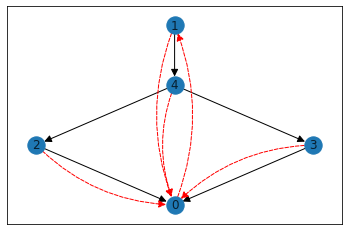

Relational frame of size 6 constructed as in Theorem 4.22.4:


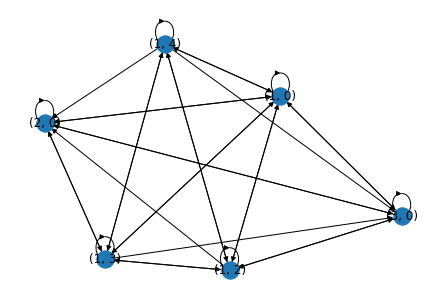

Lattice with negation from relational frame:


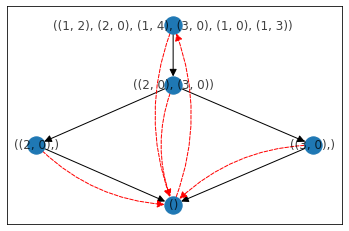

The two algebras are isomorphic.
-------------------------------
Size 5, #4
Lattice with weak pseudocomplementation:


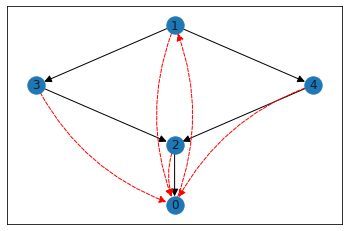

Relational frame of size 6 constructed as in Theorem 4.22.4:


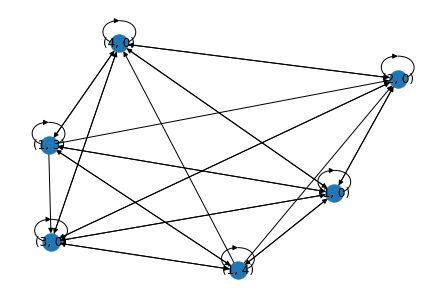

Lattice with negation from relational frame:


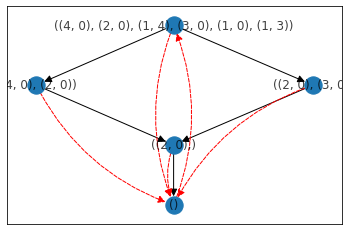

The two algebras are isomorphic.
-------------------------------
Size 5, #5
Lattice with weak pseudocomplementation:


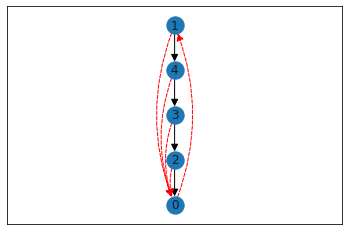

Relational frame of size 7 constructed as in Theorem 4.22.4:


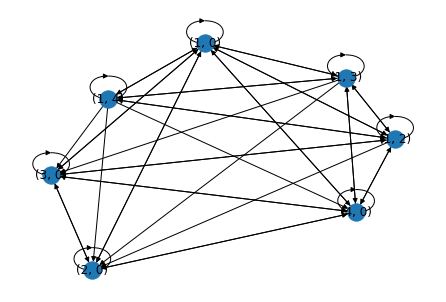

Lattice with negation from relational frame:


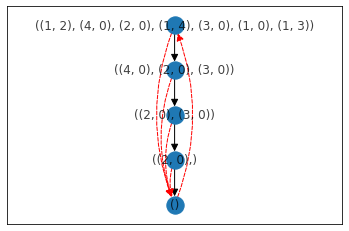

The two algebras are isomorphic.
-------------------------------
Size 5, #6
Lattice with weak pseudocomplementation:


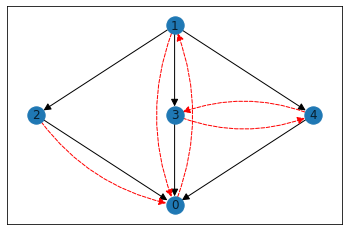

Relational frame of size 6 constructed as in Theorem 4.22.4:


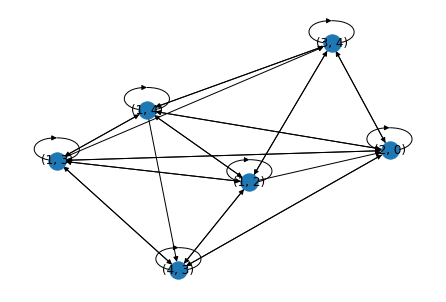

Lattice with negation from relational frame:


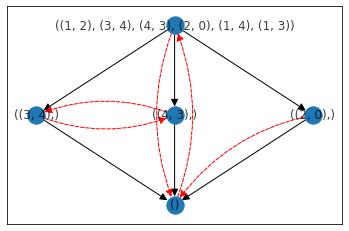

The two algebras are isomorphic.
-------------------------------
Size 5, #7
Lattice with weak pseudocomplementation:


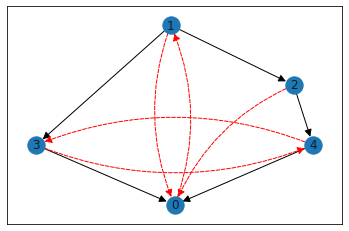

Relational frame of size 6 constructed as in Theorem 4.22.4:


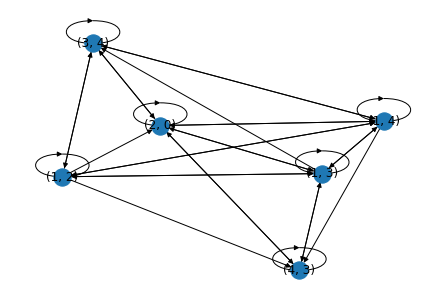

Lattice with negation from relational frame:


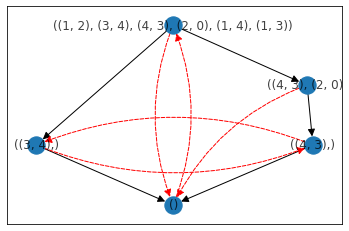

The two algebras are isomorphic.
-------------------------------
Size 5, #8
Lattice with weak pseudocomplementation:


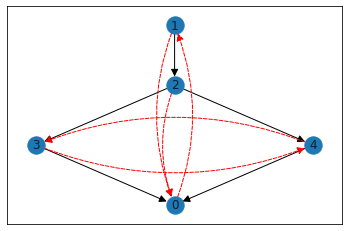

Relational frame of size 6 constructed as in Theorem 4.22.4:


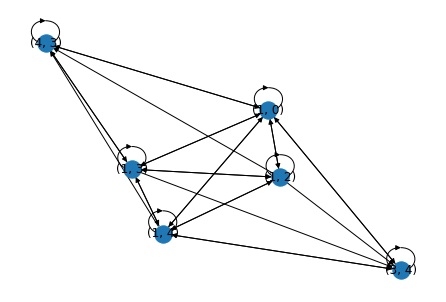

Lattice with negation from relational frame:


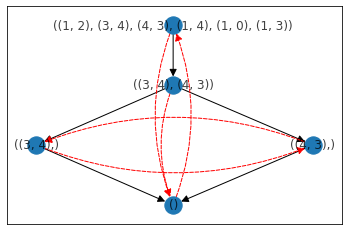

The two algebras are isomorphic.
-------------------------------
Size 5, #9
Lattice with weak pseudocomplementation:


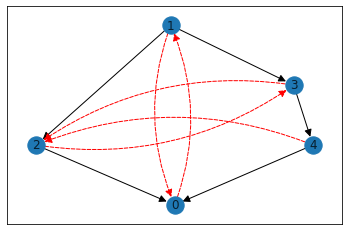

Relational frame of size 6 constructed as in Theorem 4.22.4:


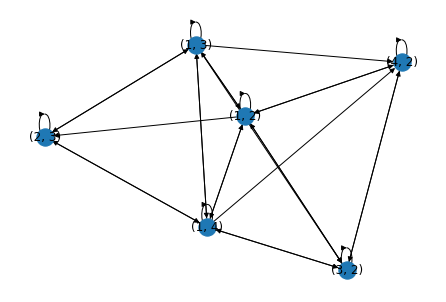

Lattice with negation from relational frame:


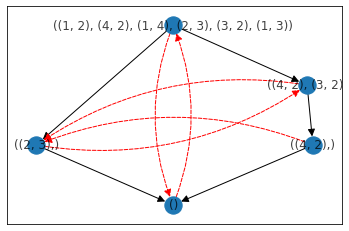

The two algebras are isomorphic.
-------------------------------
####################################################
Lattices of size 6 with weak pseudocomplementations:
Size 6, #1
Lattice with weak pseudocomplementation:


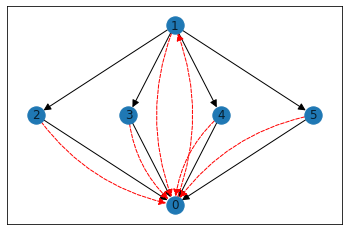

Relational frame of size 8 constructed as in Theorem 4.22.4:


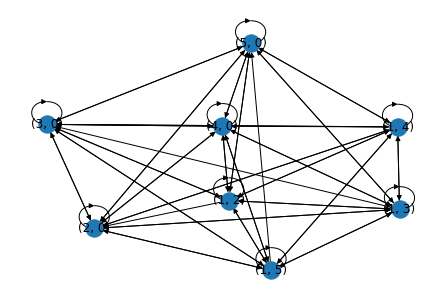

Lattice with negation from relational frame:


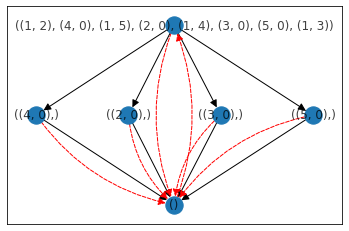

The two algebras are isomorphic.
-------------------------------
Size 6, #2
Lattice with weak pseudocomplementation:


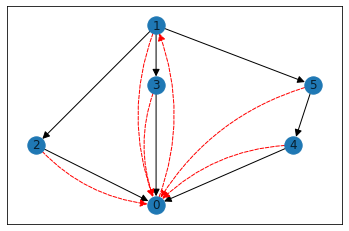

Relational frame of size 8 constructed as in Theorem 4.22.4:


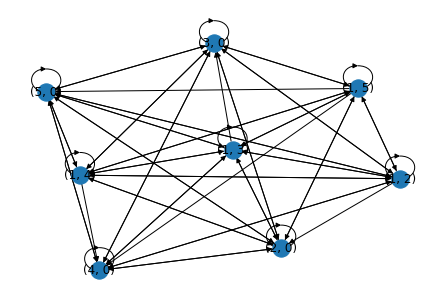

Lattice with negation from relational frame:


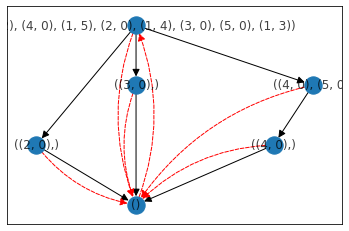

The two algebras are isomorphic.
-------------------------------
Size 6, #3
Lattice with weak pseudocomplementation:


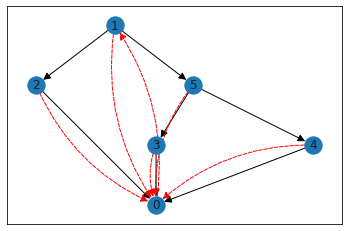

Relational frame of size 7 constructed as in Theorem 4.22.4:


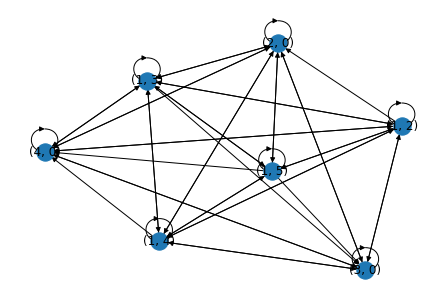

Lattice with negation from relational frame:


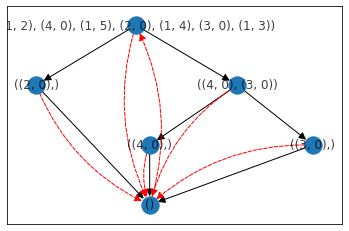

The two algebras are isomorphic.
-------------------------------
Size 6, #4
Lattice with weak pseudocomplementation:


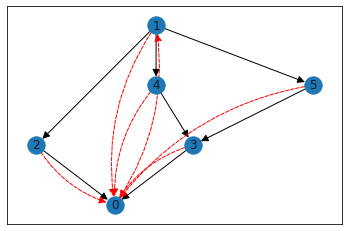

Relational frame of size 7 constructed as in Theorem 4.22.4:


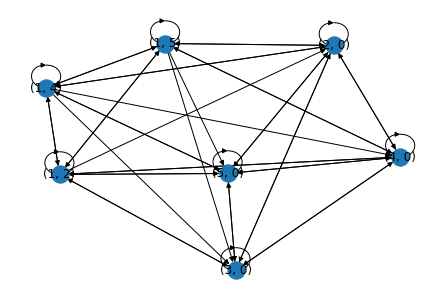

Lattice with negation from relational frame:


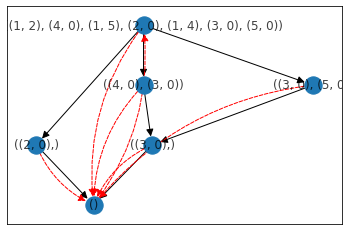

The two algebras are isomorphic.
-------------------------------
Size 6, #5
Lattice with weak pseudocomplementation:


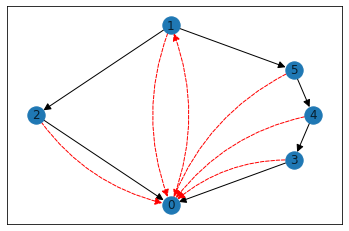

Relational frame of size 8 constructed as in Theorem 4.22.4:


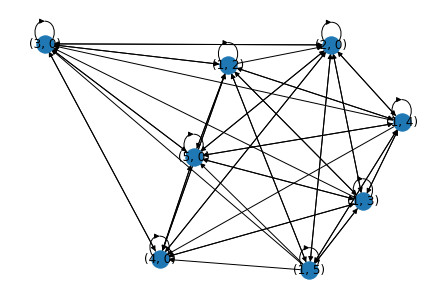

Lattice with negation from relational frame:


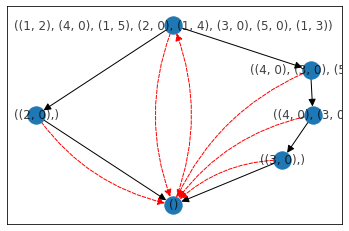

The two algebras are isomorphic.
-------------------------------
Size 6, #6
Lattice with weak pseudocomplementation:


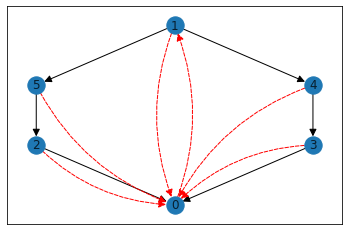

Relational frame of size 8 constructed as in Theorem 4.22.4:


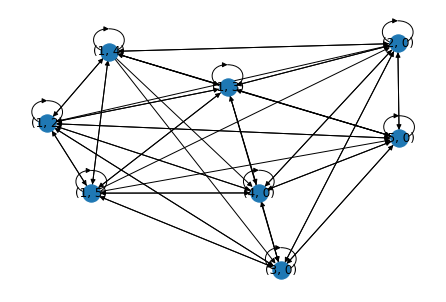

Lattice with negation from relational frame:


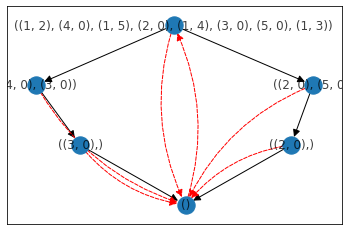

The two algebras are isomorphic.
-------------------------------
Size 6, #7
Lattice with weak pseudocomplementation:


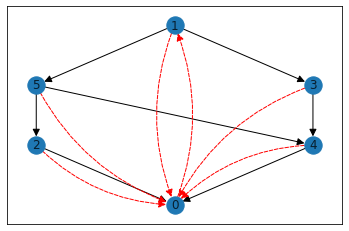

Relational frame of size 6 constructed as in Theorem 4.22.4:


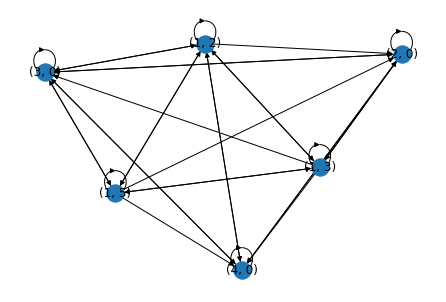

Lattice with negation from relational frame:


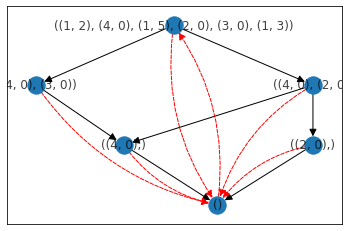

The two algebras are isomorphic.
-------------------------------
Size 6, #8
Lattice with weak pseudocomplementation:


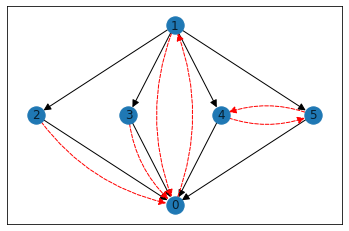

Relational frame of size 8 constructed as in Theorem 4.22.4:


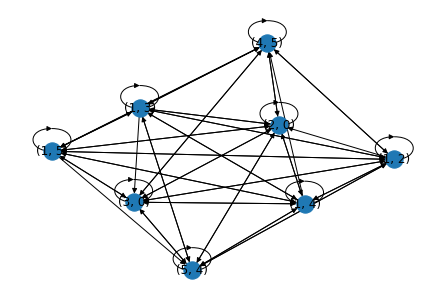

Lattice with negation from relational frame:


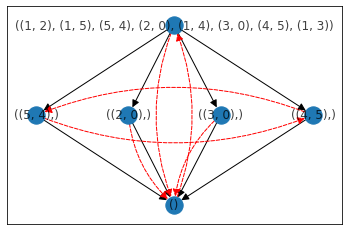

The two algebras are isomorphic.
-------------------------------
Size 6, #9
Lattice with weak pseudocomplementation:


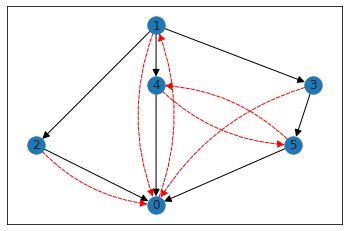

Relational frame of size 8 constructed as in Theorem 4.22.4:


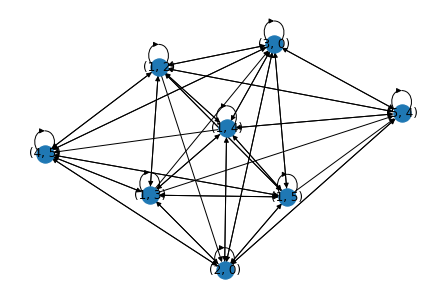

Lattice with negation from relational frame:


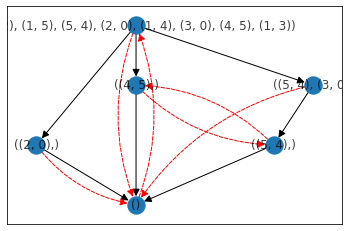

The two algebras are isomorphic.
-------------------------------
Size 6, #10
Lattice with weak pseudocomplementation:


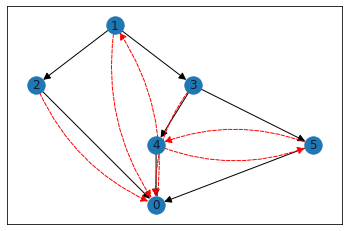

Relational frame of size 7 constructed as in Theorem 4.22.4:


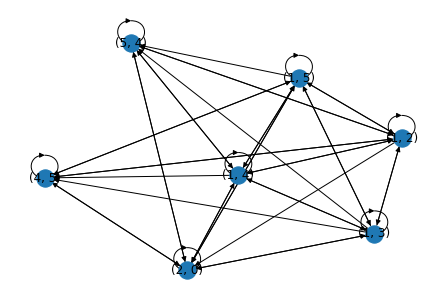

Lattice with negation from relational frame:


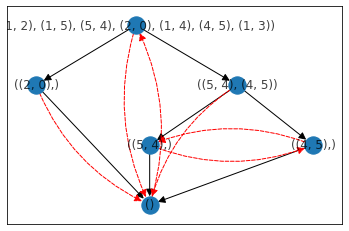

The two algebras are isomorphic.
-------------------------------
Size 6, #11
Lattice with weak pseudocomplementation:


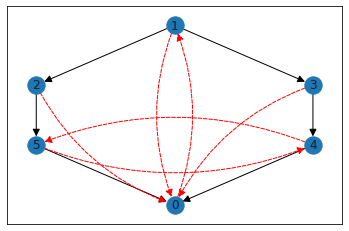

Relational frame of size 8 constructed as in Theorem 4.22.4:


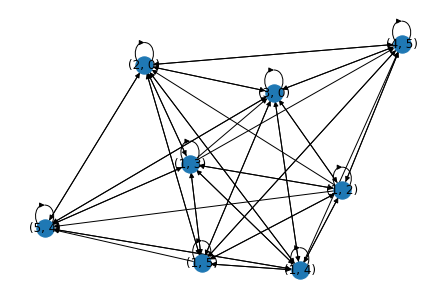

Lattice with negation from relational frame:


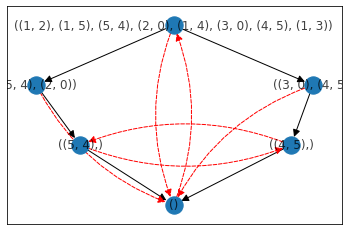

The two algebras are isomorphic.
-------------------------------
Size 6, #12
Lattice with weak pseudocomplementation:


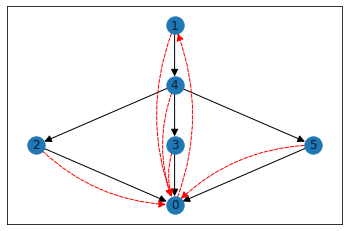

Relational frame of size 8 constructed as in Theorem 4.22.4:


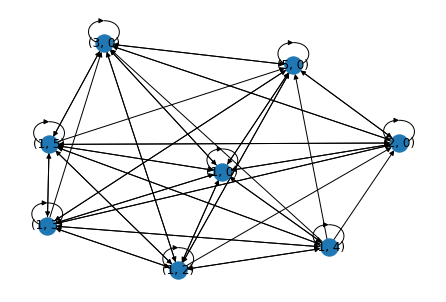

Lattice with negation from relational frame:


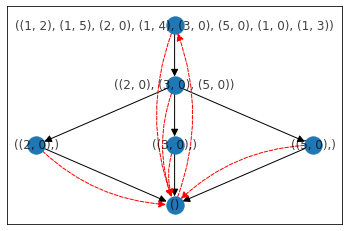

The two algebras are isomorphic.
-------------------------------
Size 6, #13
Lattice with weak pseudocomplementation:


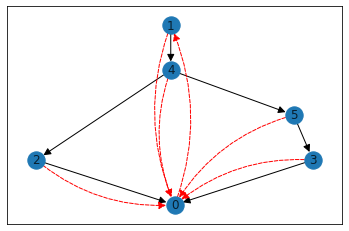

Relational frame of size 8 constructed as in Theorem 4.22.4:


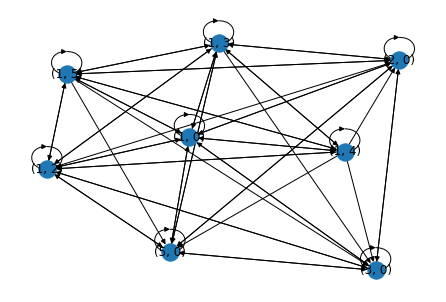

Lattice with negation from relational frame:


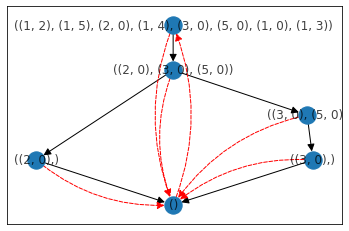

The two algebras are isomorphic.
-------------------------------
Size 6, #14
Lattice with weak pseudocomplementation:


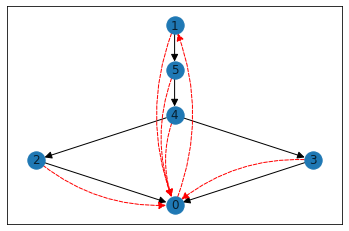

Relational frame of size 8 constructed as in Theorem 4.22.4:


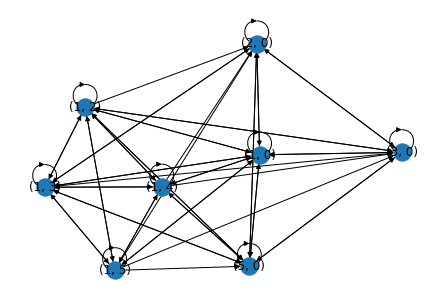

Lattice with negation from relational frame:


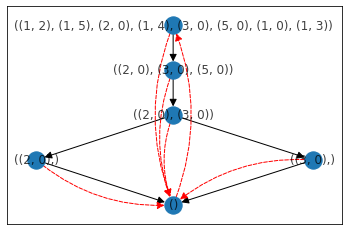

The two algebras are isomorphic.
-------------------------------
Size 6, #15
Lattice with weak pseudocomplementation:


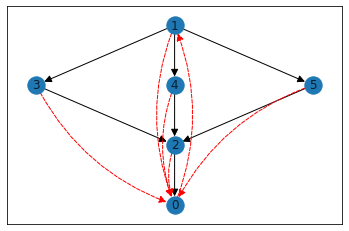

Relational frame of size 8 constructed as in Theorem 4.22.4:


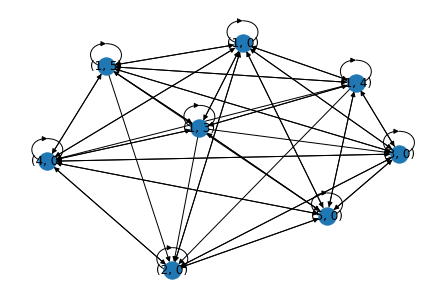

Lattice with negation from relational frame:


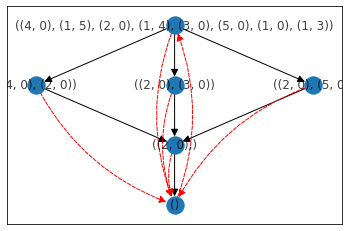

The two algebras are isomorphic.
-------------------------------
Size 6, #16
Lattice with weak pseudocomplementation:


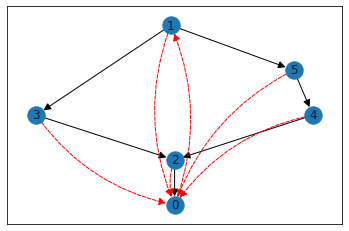

Relational frame of size 8 constructed as in Theorem 4.22.4:


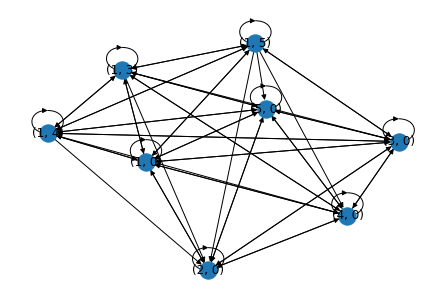

Lattice with negation from relational frame:


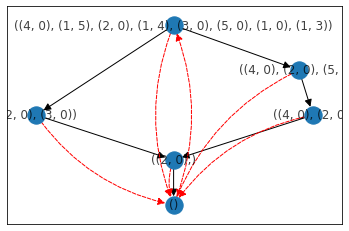

The two algebras are isomorphic.
-------------------------------
Size 6, #17
Lattice with weak pseudocomplementation:


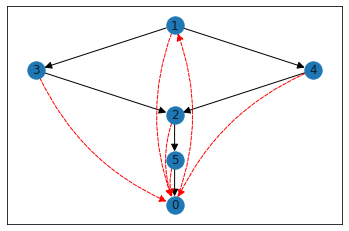

Relational frame of size 8 constructed as in Theorem 4.22.4:


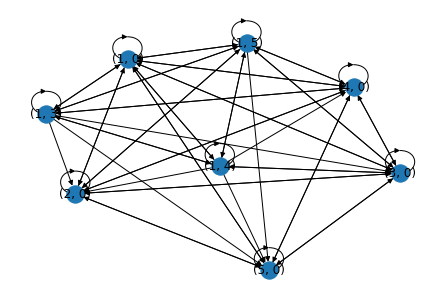

Lattice with negation from relational frame:


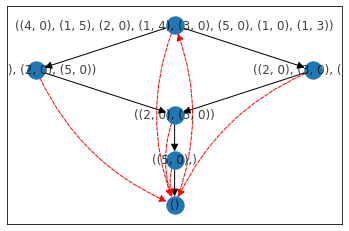

The two algebras are isomorphic.
-------------------------------
Size 6, #18
Lattice with weak pseudocomplementation:


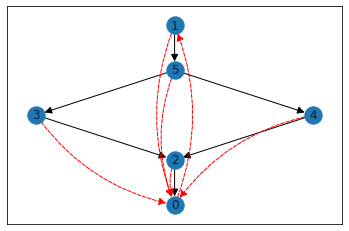

Relational frame of size 7 constructed as in Theorem 4.22.4:


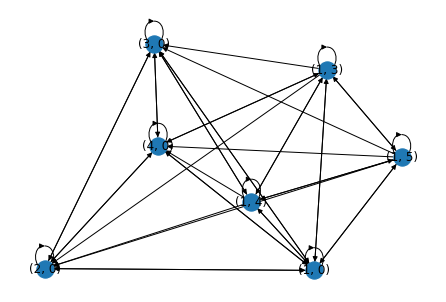

Lattice with negation from relational frame:


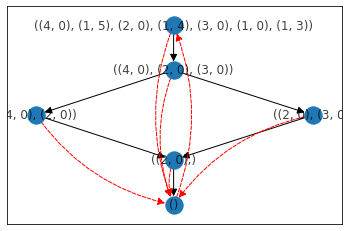

The two algebras are isomorphic.
-------------------------------
Size 6, #19
Lattice with weak pseudocomplementation:


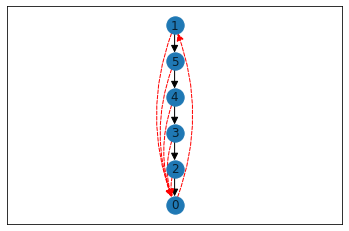

Relational frame of size 9 constructed as in Theorem 4.22.4:


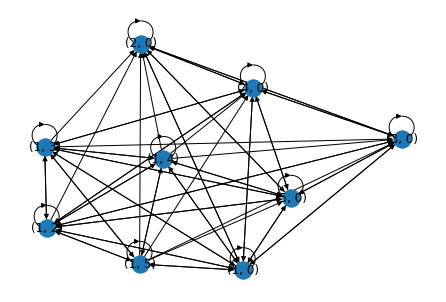

Lattice with negation from relational frame:


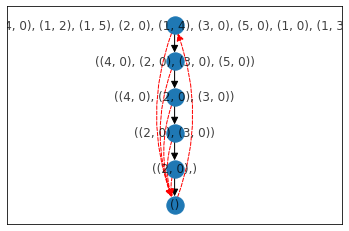

The two algebras are isomorphic.
-------------------------------
Size 6, #20
Lattice with weak pseudocomplementation:


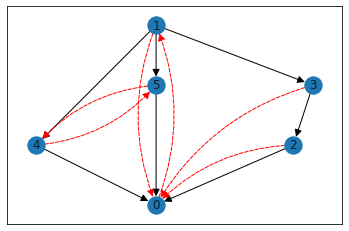

Relational frame of size 8 constructed as in Theorem 4.22.4:


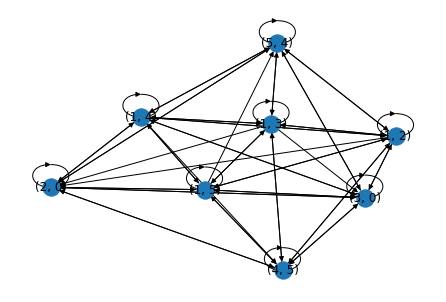

Lattice with negation from relational frame:


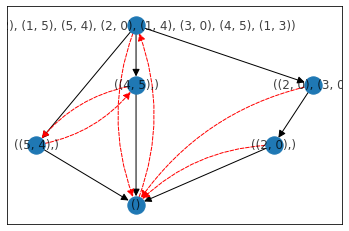

The two algebras are isomorphic.
-------------------------------
Size 6, #21
Lattice with weak pseudocomplementation:


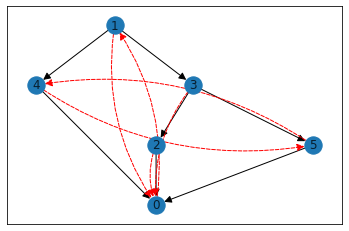

Relational frame of size 7 constructed as in Theorem 4.22.4:


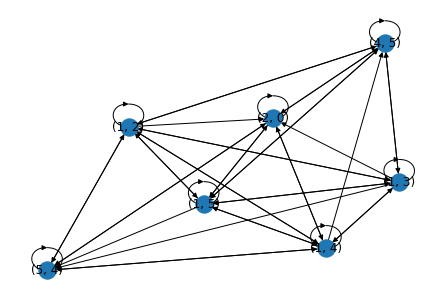

Lattice with negation from relational frame:


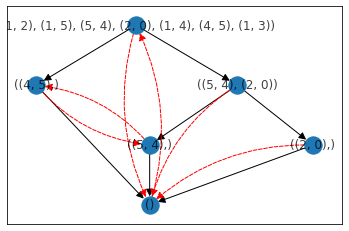

The two algebras are isomorphic.
-------------------------------
Size 6, #22
Lattice with weak pseudocomplementation:


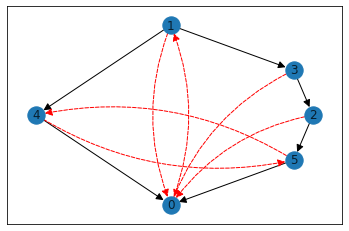

Relational frame of size 8 constructed as in Theorem 4.22.4:


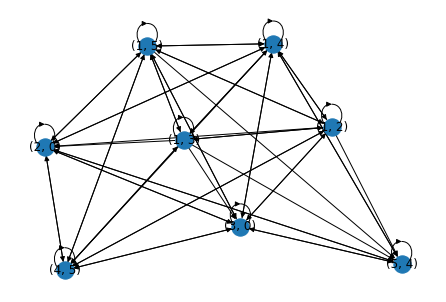

Lattice with negation from relational frame:


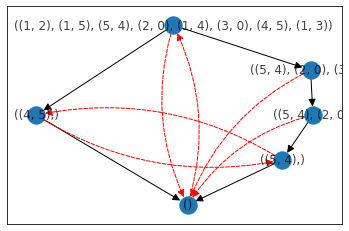

The two algebras are isomorphic.
-------------------------------
Size 6, #23
Lattice with weak pseudocomplementation:


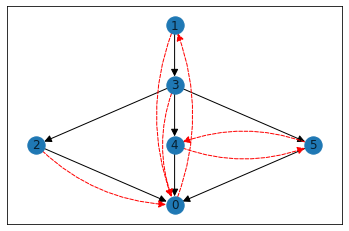

Relational frame of size 8 constructed as in Theorem 4.22.4:


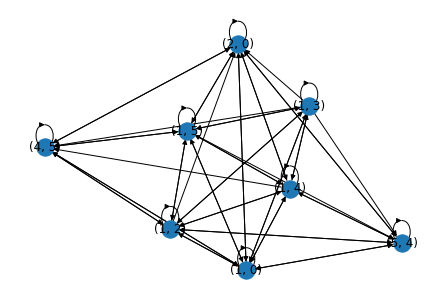

Lattice with negation from relational frame:


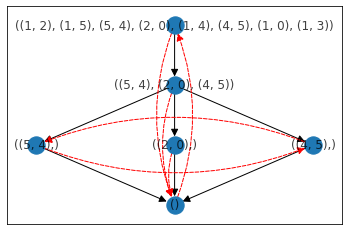

The two algebras are isomorphic.
-------------------------------
Size 6, #24
Lattice with weak pseudocomplementation:


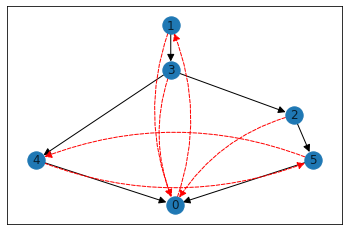

Relational frame of size 8 constructed as in Theorem 4.22.4:


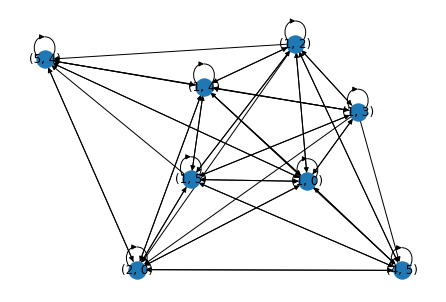

Lattice with negation from relational frame:


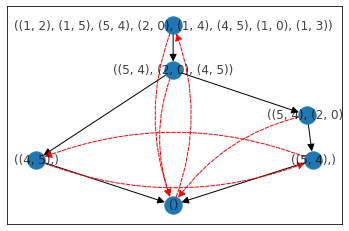

The two algebras are isomorphic.
-------------------------------
Size 6, #25
Lattice with weak pseudocomplementation:


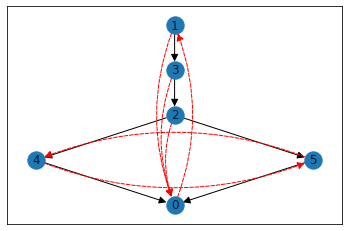

Relational frame of size 8 constructed as in Theorem 4.22.4:


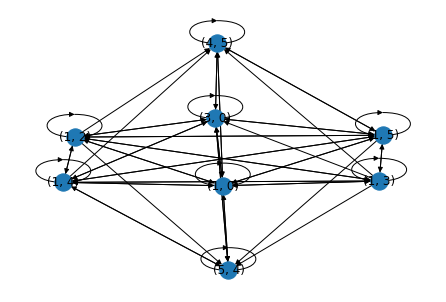

Lattice with negation from relational frame:


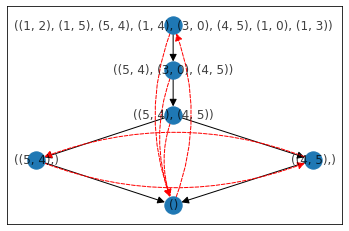

The two algebras are isomorphic.
-------------------------------
Size 6, #26
Lattice with weak pseudocomplementation:


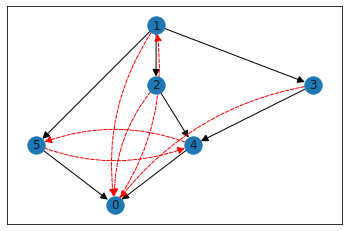

Relational frame of size 7 constructed as in Theorem 4.22.4:


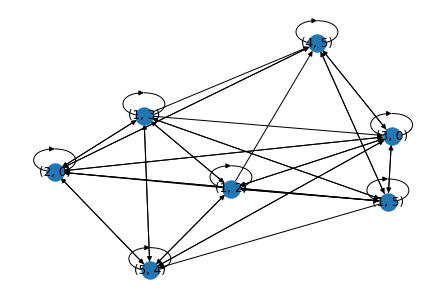

Lattice with negation from relational frame:


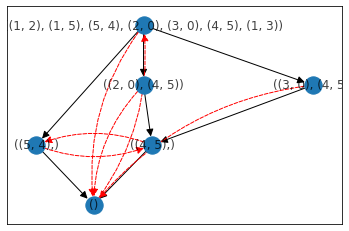

The two algebras are isomorphic.
-------------------------------
Size 6, #27
Lattice with weak pseudocomplementation:


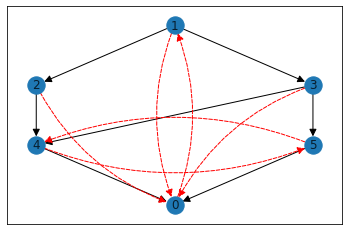

Relational frame of size 6 constructed as in Theorem 4.22.4:


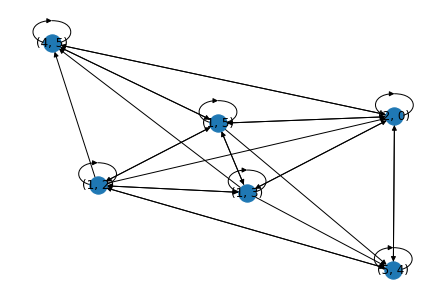

Lattice with negation from relational frame:


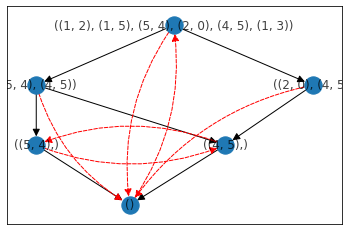

The two algebras are isomorphic.
-------------------------------
Size 6, #28
Lattice with weak pseudocomplementation:


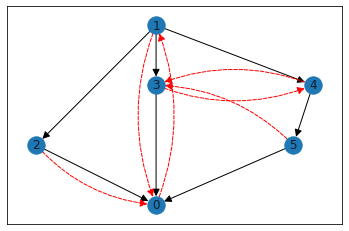

Relational frame of size 8 constructed as in Theorem 4.22.4:


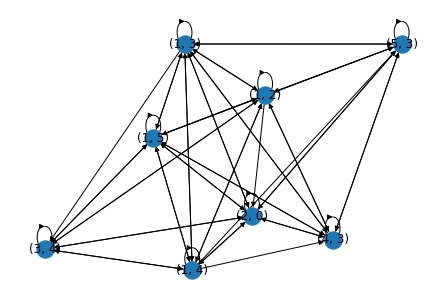

Lattice with negation from relational frame:


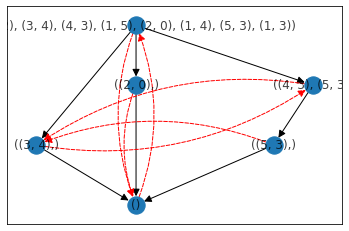

The two algebras are isomorphic.
-------------------------------
Size 6, #29
Lattice with weak pseudocomplementation:


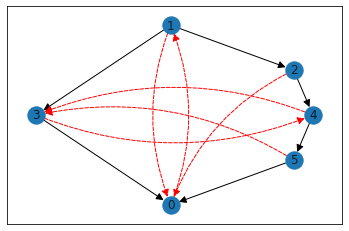

Relational frame of size 8 constructed as in Theorem 4.22.4:


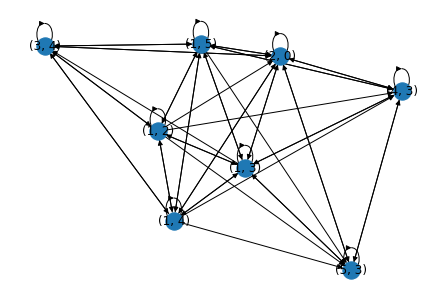

Lattice with negation from relational frame:


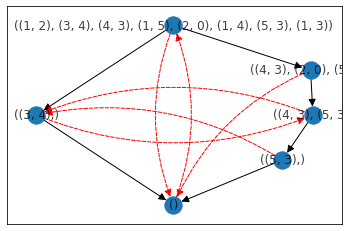

The two algebras are isomorphic.
-------------------------------
Size 6, #30
Lattice with weak pseudocomplementation:


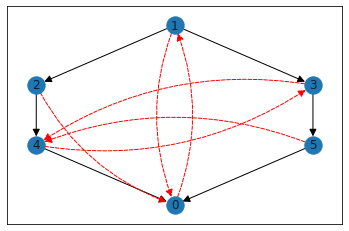

Relational frame of size 8 constructed as in Theorem 4.22.4:


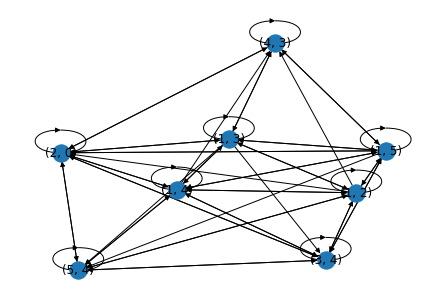

Lattice with negation from relational frame:


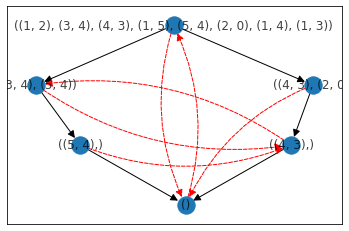

In [57]:
for lat_size in range(2,7):

    print(f"####################################################")
    print(f"Lattices of size {lat_size} with weak pseudocomplementations:")

    lat_neg = lattice_orders_and_neg_dicts_from(f"lattices-with-weak-pseudo/weakpseudo{lat_size}.out")
    nx_algebras = nx_algebras_from(f"lattices-with-weak-pseudo/weakpseudo{lat_size}.out")

    for n in range(len(lat_neg)):

        print(f"Size {lat_size}, #{n+1}")
        print("Lattice with weak pseudocomplementation:")
        l = nx_algebras[n]
        display_lattice_with_neg(l)

        dom = set(frame_from_lat_with_weak_pseudo(lat_neg[n][0],lat_neg[n][1],lat_size)[0])
        rel = frame_from_lat_with_weak_pseudo(lat_neg[n][0],lat_neg[n][1],lat_size)[1]

        k = len(dom)
        print(f"Relational frame of size {k} constructed as in Theorem 4.22.4:")
        draw_flipped_digraph(rel,dom)

        print("Lattice with negation from relational frame:")
        l2 = lattice_with_neg(rel,dom)
        display_lattice_with_neg(l2)

        if nx.is_isomorphic(l,l2):
            print("The two algebras are isomorphic.")
    
        else:
            print("The two algebras are NOT isomorphic.")

        print("-------------------------------")